In [20]:
import pickle as pkl
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import boxcox
import itertools
from scipy.special import inv_boxcox
from scipy.stats import boxcox
import warnings
from statsmodels.stats.anova import anova_lm
# Für die Modellierung
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

###############################################################################
# 0) Daten laden
###############################################################################

DATA_PATH = "feinstaubdataexercise.pickle"

with open(DATA_PATH, 'rb') as file:
    dailymeansdata = pkl.load(file)

# Dictionary Keys: 'Graz-DB' und 'Kalkleiten'
df_graz = dailymeansdata["Graz-DB"].copy()   # Das DataFrame, auf das wir uns konzentrieren
df_kalk = dailymeansdata["Kalkleiten"].copy()  # Für spätere Inversions-Variable (temp-Diff)

# Index ist DateTime mit TimeZone, optional kann man die Zeitzone droppen oder konvertieren
df_graz.index = df_graz.index.tz_localize(None)
df_kalk.index = df_kalk.index.tz_localize(None)

# Ein kurzer Blick auf die Daten
print("---- Info Graz-DB ----")
df_graz.info()
print(df_graz.head())

print("\n---- Info Kalkleiten ----")
df_kalk.info()
print(df_kalk.head())

# Scheinbar gibt es ein paar null-Werte in no2 und pm10
# Für Kalkleiten gibt es scheinbar nur die Temperaturen auch hier finden wir einige null-Werte. (siehe PUnkt 1b)

---- Info Graz-DB ----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2161 entries, 2015-01-01 to 2020-12-31
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   day_type       2161 non-null   category
 1   humidity       2161 non-null   float64 
 2   temp           2161 non-null   float64 
 3   no2            2157 non-null   float64 
 4   pm10           2146 non-null   float64 
 5   prec           2161 non-null   float64 
 6   windspeed      2161 non-null   float64 
 7   peak_velocity  2161 non-null   float64 
dtypes: category(1), float64(7)
memory usage: 137.2 KB
                  day_type   humidity      temp        no2        pm10  \
DateTime                                                                 
2015-01-01  Sunday/Holiday  76.086280 -3.114223  55.883530  113.757540   
2015-01-02         Weekday  84.450230  0.345273  82.513820   94.340850   
2015-01-03        Saturday  89.667440  1.184227  65.

In [2]:
###############################################################################
# 1) Erste Exploration: Zusammenhänge, Verteilung, Missing Data
###############################################################################

# a) In welchen Bereichen bewegen sich die Variablen?
desc = df_graz.describe()
print("\n--- DESCRIBE (Graz-DB) ---")
print(desc)


--- DESCRIBE (Graz-DB) ---
          humidity         temp          no2         pm10         prec  \
count  2161.000000  2161.000000  2157.000000  2146.000000  2161.000000   
mean     72.880523    11.567293    40.597098    27.435716     1.813781   
std      12.893109     8.289439    14.191078    15.822951     5.069202   
min      37.992634   -10.208468     8.024886     2.248819     0.000000   
25%      63.312733     4.660096    30.276724    16.907141     0.000000   
50%      72.677450    11.861993    38.872180    23.465809     0.000000   
75%      83.259100    18.658024    48.544228    33.629410     0.700892   
max      97.546480    28.999367   104.850220   153.803670    69.523677   

         windspeed  peak_velocity  
count  2161.000000    2161.000000  
mean      0.618586       5.935617  
std       0.351442       3.320835  
min       0.114222       1.322557  
25%       0.404981       3.350479  
50%       0.534850       5.025719  
75%       0.715614       7.847174  
max       3.00058

In [3]:
# b) Missing Data Visualisierung
# Wir sehen bereits in df_graz.info(), dass no2 und pm10 Lücken haben.
# Hier noch eine genauere Aufstellung wo:
print("\n--- Missing Values Graz ---")
print(df_graz.isnull().sum())

print("\n--- Missing Values Kalkleiten ---")
print(df_kalk.isnull().sum())


--- Missing Values Graz ---
day_type          0
humidity          0
temp              0
no2               4
pm10             15
prec              0
windspeed         0
peak_velocity     0
dtype: int64

--- Missing Values Kalkleiten ---
day_type     0
temp        21
dtype: int64


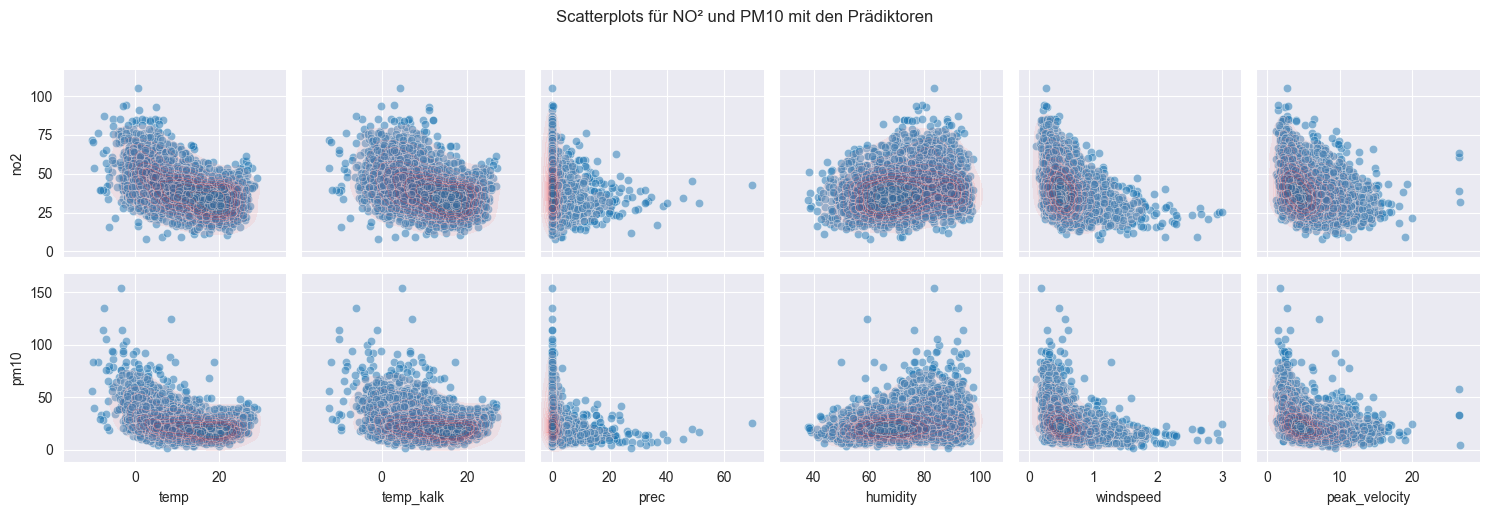

In [4]:
# c) Paarweise Scatterplots, um einen Eindruck der Zusammenhänge zu gewinnen
#   (ohne day_type, da kategorisch)
# Temperaturdaten von Kalkleiten hinzufügen
df_combined = pd.merge(
    df_graz,
    df_kalk[["temp"]].rename(columns={"temp": "temp_kalk"}),
    left_index=True,
    right_index=True,
    how="inner"
)

# Fokus-Spalten: NO₂ und PM10 als Zielvariablen, Prädiktoren als X-Achsen
cols_focus = ["no2", "pm10", "temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"]

# Daten für die Visualisierung extrahieren
df_focus = df_combined[cols_focus]

# PairGrid: Nur Scatterplots für NO₂ und PM10 mit Prädiktoren
g = sns.PairGrid(df_focus, y_vars=["no2", "pm10"], x_vars=["temp", "temp_kalk", "prec", "humidity", "windspeed", "peak_velocity"])
g.map(sns.scatterplot, alpha=0.5)  # Scatterplot
g.map(sns.kdeplot, color="red", fill=True, alpha=0.2)  # Dichtekurven

# Titel und Layout anpassen
g.fig.suptitle("Scatterplots für NO² und PM10 mit den Prädiktoren", y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)  # Platz für den Titel

# Plot speichern und anzeigen
plt.savefig("scatter_no2_pm10_prädiktoren.png")
plt.show()

# Interessant erscheinen hier vorallem folgende Zusammenhänge:
# 1) NO² und pm10 mit Temperatur (nicht linear)
# 2) NO² mit pm10 (linear) soll aber nicht in betracht gezogen werden.
# 3) pm10 und prec (Niederschlag in l/m²), könnte auf eine hyperbolische Beziehung hindeuten
# 4) windspeed und pm10 scheinen negativ zu korrelieren.


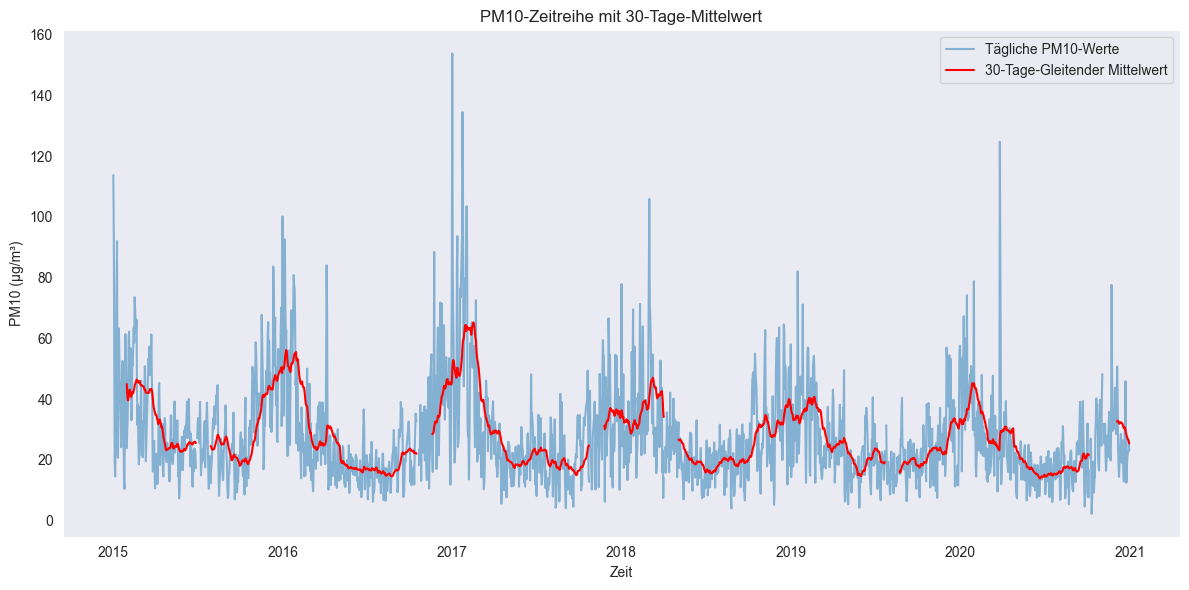

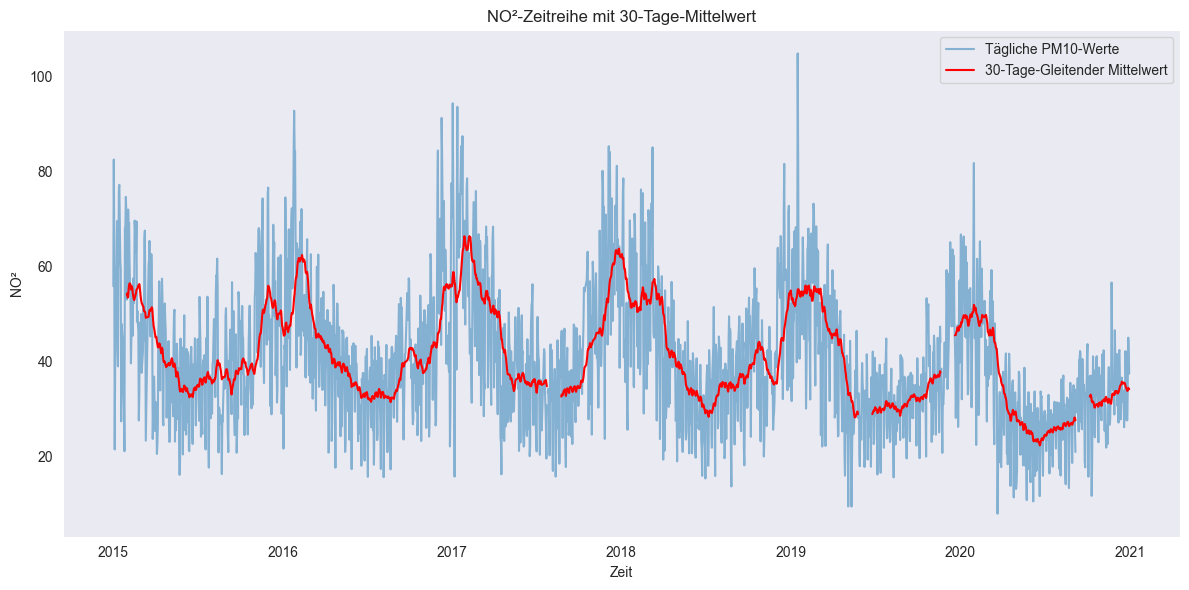

In [5]:
# Plotten von Feinstaub und NO² über die Zeit um Muster/Trends zu erkennen:
# Gleitender Durchschnitt
df_graz["pm10_rolling"] = df_graz["pm10"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["pm10"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["pm10_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("PM10 (µg/m³)")
plt.title("PM10-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

df_graz["no2_rolling"] = df_graz["no2"].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_graz.index, df_graz["no2"], label="Tägliche PM10-Werte", alpha=0.5)
plt.plot(df_graz.index, df_graz["no2_rolling"], label="30-Tage-Gleitender Mittelwert", color="red")
plt.xlabel("Zeit")
plt.ylabel("NO²")
plt.title("NO²-Zeitreihe mit 30-Tage-Mittelwert")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# Deutlich wird hier ein Phasischer Verlauf vermutlich korrelierend mit den Wintermonaten (Heiz Saison, mehr Autoverkehr etc.)
# Zu diesem Zweck verwenden wir eine Heatmap um diese Vermutung zu Untersuchen.

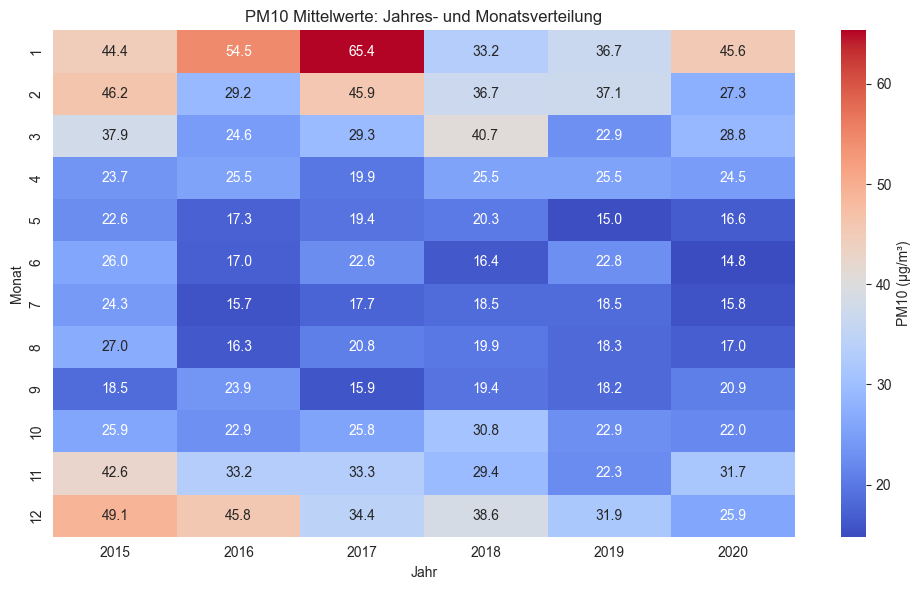

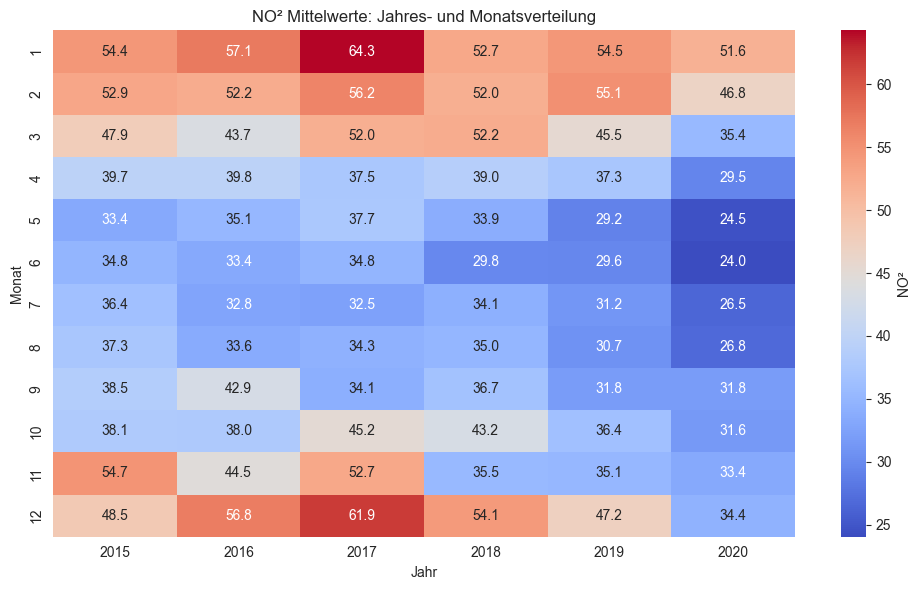

In [6]:
# Monat und Jahr aus dem Index extrahieren
df_graz["year"] = df_graz.index.year
df_graz["month"] = df_graz.index.month

# Pivot-Tabelle erstellen
heatmap_data = df_graz.pivot_table(
    values="pm10", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "PM10 (µg/m³)"})
plt.title("PM10 Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

heatmap_data = df_graz.pivot_table(
    values="no2", index="month", columns="year", aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "NO²"})
plt.title("NO² Mittelwerte: Jahres- und Monatsverteilung")
plt.xlabel("Jahr")
plt.ylabel("Monat")
plt.tight_layout()
plt.show()

# Es ist eindeutig ersichtlich, dass um die Wintermonate (11. - 2.) Die Belastung am höchsten ist.

In [37]:
###############################################################################
# 2) Erstes Modell für pm10 und no2 (2015-2019) - Lineare Regression
###############################################################################

# a) Train/Test Split: 2015-2019 Trainingsdaten, 2020 Testdaten
train_graz_df = df_graz.loc[(df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)].copy()
test_graz_df = df_graz.loc[(df_graz.index.year == 2020)].copy()

train_kalk_df = df_kalk.loc[(df_kalk.index.year >= 2015) & (df_kalk.index.year <= 2019)].copy()
test_kalk_df = df_kalk.loc[(df_kalk.index.year == 2020)].copy()
# Mit den vielversprechenden Daten sieht unser Modell nicht besonders gut aus. (Adj. R-squared:	0.341)

In [40]:
regression_modell_no2 = smf.ols("no2 ~ temp + windspeed + prec", data=train_graz_df).fit()
regression_modell_no2.summary()
# Gleiches gilt hier bie NO²

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     347.9
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          6.57e-178
Time:                        16:53:24   Log-Likelihood:                -6882.3
No. Observations:                1792   AIC:                         1.377e+04
Df Residuals:                    1788   BIC:                         1.379e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9702      0.603     97.759      0.000      57.787      60.153
temp          -0.7443      0.033    -22.757      0.000      -0.808      -0.680
windspeed    -12.4917      0.761    -16.420      0.000     -13.984     -11.000
prec          -0.2374      0.051     -4.628      0.000      -0.338      -0.137
==============================================================================
Omnibus:                       20.454   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.875
Skew:                           0.263   Prob(JB):                     2.93e-05
Kurtosis:                       3.058   Cond. No.                         48.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# b) Daher versuchen wir die besten Parameter heraus zu finden. Dazu definieren wir eine Methode die iterativ jede mögliche Kombination aller Variablen zueinander ausprobiert (mit und ohne Wurzeltransformation und mit und ohne hyperbolischer Funktion) um zu ermitteln welche Kombination von Variablen uns den besten R² Adj. liefert.

def find_best_model_with_anova(data, response, predictors):
    """
    Findet das beste OLS-Regressionsmodell für eine gegebene Zielvariable und Prädiktoren,
    unter Berücksichtigung sowohl der ursprünglichen als auch der transformierten Prädiktoren
    (I(1/(var + 1)) und sqrt(var + 1)). Führt anschließend einen ANOVA-Test durch, um die
    Signifikanz des Modells zu bewerten.

    Parameters:
    - data: pandas DataFrame, die die Daten enthält.
    - response: string, Name der Zielvariable (z.B. "pm10").
    - predictors: list of strings, Namen der Prädiktorvariablen (z.B. ["temp", "prec", "windspeed"]).

    Returns:
    - best_formula: string, die Formel des besten Modells.
    - best_model: statsmodels RegressionResultsWrapper, das gefittete beste Modell.
    - best_lambda: float, der Lambda-Wert der Box-Cox-Transformation.
    - predicted_original: pandas Series, vorhergesagte Zielwerte auf der Originalskala.
    - anova_results: pandas DataFrame, Ergebnisse des ANOVA-Tests.
    """
    # Ignoriere SettingWithCopyWarning
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

    best_adj_r2 = -np.inf
    best_formula = None
    best_model = None
    best_lambda = None
    predicted_original = None
    anova_results = None

    # Schritt 1: Fehlende Werte in der Zielvariable und den Prädiktoren entfernen und eine Kopie erstellen
    data = data.dropna(subset=[response] + predictors).copy()

    # Schritt 2: Sicherstellen, dass die Zielvariable positiv ist für Box-Cox
    if (data[response] <= 0).any():
        shift = 1 - data[response].min()  # Verschiebung, um alle Werte > 0 zu machen
        data[response] = data[response] + shift
    else:
        shift = 0

    # Schritt 3: Box-Cox-Transformation der Zielvariable durchführen
    boxcox_transformed, lambda_boxcox = boxcox(data[response])
    data['boxcox_response'] = boxcox_transformed
    print(f"Optimaler Lambda-Wert für Box-Cox: {lambda_boxcox}")

    # Schritt 4: Definiere Transformationen
    # Für jede Prädiktorvariable: 'none', 'inv', 'sqrt'
    transformation_options = ['none', 'inv', 'sqrt']

    # Schritt 5: Iteration über alle möglichen nicht-leeren Teilmengen der Prädiktoren
    for k in range(1, len(predictors) + 1):
        for subset in itertools.combinations(predictors, k):
            # Für jede Teilmenge alle möglichen Transformationen durchgehen
            # Transformation pro Prädiktor: 'none', 'inv', 'sqrt'
            for transform_flags in itertools.product(transformation_options, repeat=k):
                terms = []
                valid = True
                for var, transform in zip(subset, transform_flags):
                    if transform == 'inv':
                        # Überprüfen, ob 1 / (var + 1) gültig ist (keine Division durch Null oder negative Werte)
                        if (data[var] + 1 <= 0).any():
                            valid = False
                            break
                        term = f"I(1 / ({var} + 1))"
                    elif transform == 'sqrt':
                        # Überprüfen, ob sqrt(var + 1) gültig ist (var + 1 >= 0)
                        if (data[var] + 1 < 0).any():
                            valid = False
                            break
                        term = f"I(np.sqrt({var} + 1))"
                    else:
                        term = var
                    terms.append(term)
                if not valid:
                    continue  # Überspringen, wenn die Transformation ungültig ist
                # Formel erstellen
                formula = f"boxcox_response ~ " + " + ".join(terms)
                try:
                    model = smf.ols(formula, data=data).fit()
                    adj_r2 = model.rsquared_adj
                    if adj_r2 > best_adj_r2:
                        best_adj_r2 = adj_r2
                        best_formula = formula
                        best_model = model
                        best_lambda = lambda_boxcox
                except Exception as e:
                    # Fehler beim Fitting des Modells behandeln
                    print(f"Fehler beim Fitten des Modells: {formula}. Fehler: {e}")
                    continue

    # Schritt 6: Wenn ein Bestmodell gefunden wurde, inverse Box-Cox-Transformation der Vorhersagen durchführen
    if best_model is not None:
        # Berechne die Vorhersagen auf der Box-Cox-Skala
        boxcox_fitted = best_model.fittedvalues
        # Inverse Box-Cox-Transformation
        if best_lambda != 0:
            inverse_transform = (boxcox_fitted * best_lambda + 1) ** (1 / best_lambda)
        else:
            inverse_transform = np.exp(boxcox_fitted)
        # Falls eine Verschiebung vorgenommen wurde, diese rückgängig machen
        if shift != 0:
            inverse_transform -= shift
        predicted_original = inverse_transform

        # Schritt 7: ANOVA-Test durchführen
        # Erstelle ein Nullmodell (nur Intercept)
        null_formula = f"boxcox_response ~ 1"
        null_model = smf.ols(null_formula, data=data).fit()

        # Führe ANOVA durch
        anova_results = anova_lm(null_model, best_model)
        print("\nANOVA Ergebnisse:")
        print(anova_results)
    else:
        print("Kein gültiges Modell gefunden.")
        return None, None, None, None, None

    return best_formula, best_model, best_lambda, predicted_original, anova_results

# Die Funktion find_best_model_with_anova gibt fünf Werte zurück:
#
# best_formula: Die Formel des besten Modells.
# best_model: Das gefittete Modellobjekt.
# best_lambda: Der optimale Lambda-Wert der Box-Cox-Transformation.
# predicted_original: Die vorhergesagten Werte auf der Originalskala.
# anova_results: Die Ergebnisse des ANOVA-Tests.


response_variable = "pm10"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity"]

best_formula, best_model, best_lambda, predicted_original, anova_results = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula)
print(best_model.summary())
# Das schaut schon besser aus! Wir konnten unser R² adj. auf 0.412 erhöhen und gleichzeitig AIC auf 1855 reduzieren, ist aber immer noch weit weg von gut.

Optimaler Lambda-Wert für Box-Cox: -0.002884805674753925

ANOVA Ergebnisse:
   df_resid         ssr  df_diff    ss_diff          F         Pr(>F)
0    1783.0  500.094996      0.0        NaN        NaN            NaN
1    1778.0  293.466565      5.0  206.62843  250.37629  8.468732e-203
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + I(1 / (windspeed + 1)) + I(1 / (peak_velocity + 1))
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     250.4
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          8.47e-203
Time:                        16:53:35   Log-Likelihood:                -921.46
No. Observations:                1784   AIC:                             1855.
Df Residuals:                  

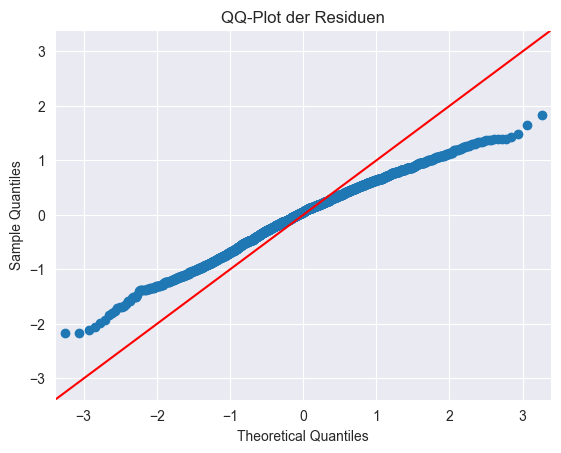

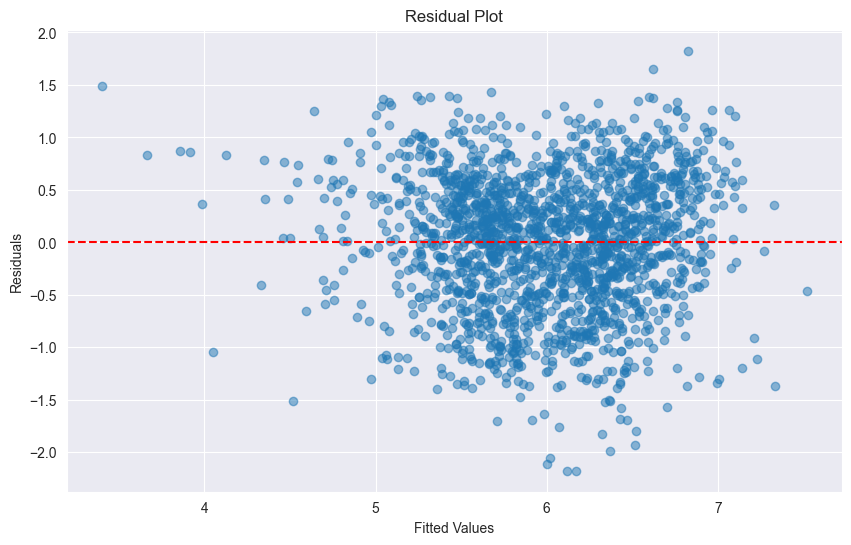

In [42]:
response_variable = "no2"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity"]

best_formula2, best_model2, best_lambda2, predicted_original2, anova_results2 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula2)
print(best_model2.summary())
# Auch hier haben wir mit unserer Methode zumindest ein besseres Modell finden können.

Optimaler Lambda-Wert für Box-Cox: 0.24371210636149118

ANOVA Ergebnisse:
   df_resid          ssr  df_diff     ss_diff           F         Pr(>F)
0    1791.0  1248.702148      0.0         NaN         NaN            NaN
1    1786.0   725.617246      5.0  523.084902  257.499292  1.628753e-207
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + peak_velocity
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     257.5
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          1.63e-207
Time:                        16:53:48   Log-Likelihood:                -1732.7
No. Observations:                1792   AIC:                             3477.
Df Residuals:                    1

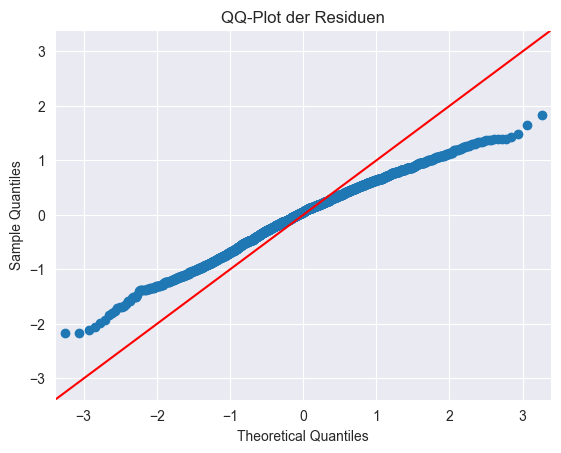

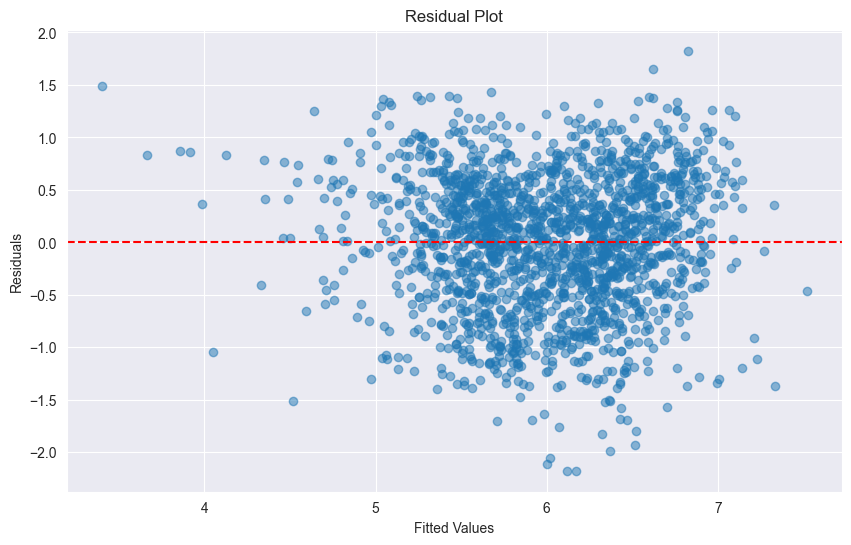


--- Modell PM10: OLS Summary ---
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     186.2
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          9.92e-160
Time:                        13:27:46   Log-Likelihood:                -7122.4
No. Observations:                1784   AIC:                         1.426e+04
Df Residuals:                    1778   BIC:                         1.429e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept   

In [44]:
###############################################################################
# 3) Inversion
###############################################################################

# a) Berechnung der Temperaturdifferenz
train_graz_df['temp_diff'] = train_graz_df['temp'] - train_kalk_df['temp']

# b) Berechnung mittels neuer Variable:
response_variable = "no2"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]
best_formula3, best_model3, best_lambda3, predicted_original3, anova_results3 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula3)
print(best_model3.summary())
# Mittels unserer neuen Variable konnten wir unser Modell nochmals verbessern!

Optimaler Lambda-Wert für Box-Cox: 0.24674971146620103

ANOVA Ergebnisse:
   df_resid          ssr  df_diff     ss_diff           F         Pr(>F)
0    1772.0  1267.740927      0.0         NaN         NaN            NaN
1    1766.0   640.596165      6.0  627.144762  288.152847  1.659852e-257
Bestes Modell-Formel: boxcox_response ~ temp + I(np.sqrt(prec + 1)) + humidity + windspeed + I(1 / (peak_velocity + 1)) + temp_diff
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     288.2
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          1.66e-257
Time:                        16:55:05   Log-Likelihood:                -1613.3
No. Observations:                1773   AIC:                             3241.
Df Residuals:         

In [46]:
response_variable = "pm10"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]
best_formula4, best_model4, best_lambda4, predicted_original4, anova_results4 = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables
)

print("Bestes Modell-Formel:", best_formula4)
print(best_model4.summary())

# Auch beim Feinstaub zeigt sich eine Verbesserung von R² Adjusted. Wir nähern uns einem guten Modell ;-)

Optimaler Lambda-Wert für Box-Cox: 0.0028454609281093482

ANOVA Ergebnisse:
   df_resid         ssr  df_diff     ss_diff           F         Pr(>F)
0    1764.0  515.591702      0.0         NaN         NaN            NaN
1    1758.0  269.280641      6.0  246.311061  268.007163  9.577946e-244
Bestes Modell-Formel: boxcox_response ~ temp + I(1 / (prec + 1)) + humidity + windspeed + I(1 / (peak_velocity + 1)) + temp_diff
                            OLS Regression Results                            
Dep. Variable:        boxcox_response   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     268.0
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          9.58e-244
Time:                        16:56:27   Log-Likelihood:                -845.19
No. Observations:                1765   AIC:                             1704.
Df Residuals:             

In [55]:
###############################################################################
# 4) Noch mehr Variablen Lagged values
###############################################################################

# Neue Variablen erstellen

# 1. Frost-Variable: 1 wenn Temperatur < 0°C, sonst 0
train_graz_df['frost'] = (train_graz_df['temp'] < 0).astype(int)

# 2. Inversions-Variable: 1 wenn Temperaturdifferenz < 0°C, sonst 0
train_graz_df['inversion'] = (train_graz_df['temp_diff'] < 0).astype(int)

# 3. Starke Wind-Variable: 1 wenn Windspeed > 0.6, sonst 0
# Stellen Sie sicher, dass die Spalte 'windspeed' korrekt benannt ist
train_graz_df['strong_wind'] = (train_graz_df['windspeed'] > 0.6).astype(int)

# 4. Jahres-Variable: Extrahieren des Jahres aus dem Index
train_graz_df['year'] = train_graz_df.index.year

# Überprüfen Sie die ersten paar Zeilen, um sicherzustellen, dass die neuen Variablen korrekt erstellt wurden
print(train_graz_df[['temp', 'temp_diff', 'frost', 'inversion', 'windspeed', 'strong_wind', 'year']].head())

# Aktualisieren der Liste der Prädiktorvariablen, falls Sie die neuen Variablen im Modell verwenden möchten
response_variable = "no2"
predictor_variables = ["temp", "prec", "humidity", "windspeed", "peak_velocity", "temp_diff"]

# Fügen Sie die neuen Variablen zu den Prädiktoren hinzu
predictor_variables_extended = predictor_variables + ['frost', 'inversion', 'strong_wind', 'year']

# Berechnung, Cave braucht sehr lang zum berechnen (auf meinem Laptop ca. 45 min)
best_formula_extended, best_model_extended, best_lambda_extended, predicted_original_extended, anova_results_extended = find_best_model_with_anova(
    data=train_graz_df,
    response=response_variable,
    predictors=predictor_variables_extended
)

print("Bestes Modell-Formel mit erweiterten Variablen:", best_formula_extended)
print(best_model_extended.summary())
# Auch mit diesen Variablen schaffen wir nur noch eine kleine Verbesserung auf 0.499 R² adj.

                temp  temp_diff  frost  inversion  windspeed  strong_wind  \
DateTime                                                                    
2015-01-01 -3.114223  -2.072470      1          1   0.285276            0   
2015-01-02  0.345273  -6.269437      0          1   0.184891            0   
2015-01-03  1.184227  -0.776218      0          1   0.298194            0   
2015-01-04  3.666447   2.535817      0          0   1.427332            1   
2015-01-05  2.146478   2.823136      0          0   1.079748            1   

            year  
DateTime          
2015-01-01  2015  
2015-01-02  2015  
2015-01-03  2015  
2015-01-04  2015  
2015-01-05  2015  
Optimaler Lambda-Wert für Box-Cox: 0.24674971146620103

ANOVA Ergebnisse:
   df_resid          ssr  df_diff     ss_diff           F         Pr(>F)
0    1772.0  1267.740927      0.0         NaN         NaN            NaN
1    1763.0   632.140600      9.0  635.600327  196.960996  6.231992e-259
Bestes Modell-Formel mit erweitert

In [71]:
regression_modell_no2 = smf.ols("no2 ~ temp + I(np.sqrt(prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + I(1 / (peak_velocity + 1)) + temp_diff + I(np.sqrt(frost + 1)) + inversion + year", data=train_graz_df).fit()
regression_modell_no2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    no2   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     219.8
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          1.67e-280
Time:                        18:50:06   Log-Likelihood:                -6554.0
No. Observations:                1773   AIC:                         1.313e+04
Df Residuals:                    1763   BIC:                         1.318e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1137.8813    335.608      3.391      0.001     479.650    1796.113
temp                          -0.7246      0.039    -18.727      0.000      -0.800      -0.649
I(np.sqrt(prec + 1))           0.5671      0.315      1.800      0.072      -0.051       1.185
humidity                      -0.3263      0.030    -10.830      0.000      -0.385      -0.267
I(np.sqrt(windspeed + 1))    -41.5146      2.934    -14.151      0.000     -47.269     -35.761
I(1 / (peak_velocity + 1))   -19.1381      5.001     -3.827      0.000     -28.946      -9.331
temp_diff                     -2.2900      0.220    -10.397      0.000      -2.722      -1.858
I(np.sqrt(frost + 1))          8.8700      2.329      3.808      0.000       4.301      13.439
inversion                      3.3441      1.067      3.135      0.002       1.252       5.436
year                          -0.5033      0.166     -3.025      0.003      -0.830      -0.177
==============================================================================
Omnibus:                        0.231   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.891   Jarque-Bera (JB):                0.288
Skew:                          -0.019   Prob(JB):                        0.866
Kurtosis:                       2.950   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
regression_modell_no2 = smf.ols("pm10 ~ temp + I(np.sqrt(prec + 1)) + humidity + I(np.sqrt(windspeed + 1)) + I(1 / (peak_velocity + 1)) + temp_diff + I(np.sqrt(frost + 1)) + inversion + year", data=train_graz_df).fit()
regression_modell_no2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   pm10   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     226.7
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          2.24e-286
Time:                        18:52:40   Log-Likelihood:                -6743.2
No. Observations:                1765   AIC:                         1.351e+04
Df Residuals:                    1755   BIC:                         1.356e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   2337.3082    380.868      6.137      0.000    1590.306    3084.310
temp                          -0.2682      0.044     -6.106      0.000      -0.354      -0.182
I(np.sqrt(prec + 1))          -1.8046      0.359     -5.022      0.000      -2.509      -1.100
humidity                      -0.0769      0.034     -2.253      0.024      -0.144      -0.010
I(np.sqrt(windspeed + 1))     -7.4499      3.351     -2.223      0.026     -14.022      -0.878
I(1 / (peak_velocity + 1))    36.0632      5.671      6.359      0.000      24.940      47.186
temp_diff                     -2.9391      0.250    -11.773      0.000      -3.429      -2.449
I(np.sqrt(frost + 1))         36.8984      2.638     13.986      0.000      31.724      42.073
inversion                      0.5769      1.208      0.478      0.633      -1.791       2.945
year                          -1.1548      0.189     -6.117      0.000      -1.525      -0.785
==============================================================================
Omnibus:                      535.457   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.209
Skew:                           1.343   Prob(JB):                         0.00
Kurtosis:                       8.423   Cond. No.                     2.92e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [74]:
# d) Hinzufügen von Lagged Variables

def add_lagged_features(df, features, lags):
    for feature in features:
        for lag in lags:
            lag_col_name = f"{feature}_lag{lag}"
            df[lag_col_name] = df[feature].shift(lag)
    return df

features_to_lag = ['temp', 'prec', 'humidity', 'windspeed', 'peak_velocity']
lags = [1, 2, 3]  # Lag1, Lag2, Lag3

combined_df = pd.concat([train_graz_df, test_graz_df])

combined_df = add_lagged_features(combined_df, features_to_lag, lags)

# Wiederaufteilen der Daten in Trainings- und Testsets
train_graz_df = combined_df.loc[(combined_df.index.year >= 2015) & (combined_df.index.year <= 2019)].copy()
test_graz_df = combined_df.loc[(combined_df.index.year == 2020)].copy()

# e) Umgang mit fehlenden Werten nach dem Shift
max_lag = max(lags)
train_graz_df = train_graz_df.iloc[max_lag:]
test_graz_df = test_graz_df.iloc[max_lag:]

# f) Definieren der Prädiktorvariablen mit Transformationen und Lagged Variables
response_variable = "pm10"

transformations = {
    'prec': 'np.sqrt(prec + 1)',
    'windspeed': 'np.sqrt(windspeed + 1)',
    'peak_velocity': '1 / (peak_velocity + 1)',
    'frost': 'np.sqrt(frost + 1)'
}

# Basis-Prädiktoren
base_predictors = ['temp', 'humidity', 'temp_diff', 'inversion', 'year']

# Transformierte Prädiktoren
transformed_predictors = [f"I({transformations[var]})" for var in ['prec', 'windspeed', 'peak_velocity', 'frost']]

# Lagged Variables
lagged_vars = [f"{feature}_lag{lag}" for feature in features_to_lag for lag in lags]

# Gesamtliste der Prädiktorvariablen
predictor_variables_extended = transformed_predictors + base_predictors + lagged_vars

# Erstellen des Formelstrings
formula = f"{response_variable} ~ " + " + ".join(predictor_variables_extended)

print("Formel:", formula)

# Führen Sie die OLS-Regression durch
regression_modell_pm10 = smf.ols(formula, data=train_graz_df).fit()

# Ausgabe der Zusammenfassung des Modells
print(regression_modell_pm10.summary())

# Noch weitere Verbesserung aber wir entfernen die Variablen mit den höchsten p-values

Formel: pm10 ~ I(np.sqrt(prec + 1)) + I(np.sqrt(windspeed + 1)) + I(1 / (peak_velocity + 1)) + I(np.sqrt(frost + 1)) + temp + humidity + temp_diff + inversion + year + temp_lag1 + temp_lag2 + temp_lag3 + prec_lag1 + prec_lag2 + prec_lag3 + humidity_lag1 + humidity_lag2 + humidity_lag3 + windspeed_lag1 + windspeed_lag2 + windspeed_lag3 + peak_velocity_lag1 + peak_velocity_lag2 + peak_velocity_lag3
                            OLS Regression Results                            
Dep. Variable:                   pm10   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     102.1
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          2.98e-310
Time:                        18:59:57   Log-Likelihood:                -6602.0
No. Observations:                1759   AIC:                         1.325e+04
Df Residuals:                    1734   BIC:   

In [49]:
###############################################################################
# 4) Noch mehr Variablen Lagged values
###############################################################################

def create_enhanced_features(df_graz, df_kalk):
    """Create enhanced features based on the air pollution data characteristics"""

    # Basic binary indicators
    df = df_graz.copy()
    df['frost'] = (df['temp'] < 0).astype(int)  # Clear frost days from temp data
    df['temp_diff'] = df['temp'] - df_kalk['temp']  # Temperature difference
    df['inversion'] = (df['temp_diff'] < 0).astype(int)  # Temperature inversion

    # Wind-related features (based on distribution in data)
    df['strong_wind'] = (df['windspeed'] > df['windspeed'].mean() + df['windspeed'].std()).astype(int)
    df['calm_conditions'] = (df['windspeed'] < df['windspeed'].quantile(0.25)).astype(int)

    # Temporal features
    df['month'] = df.index.month
    df['winter'] = df['month'].isin([12, 1, 2]).astype(int)

    # Lagged variables (shown important in time series)
    for col in ['temp', 'humidity', 'windspeed', 'prec']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)

    # Rolling means (3-day window based on visible patterns)
    for col in ['temp', 'humidity', 'windspeed']:
        df[f'{col}_3day_mean'] = df[col].rolling(window=3).mean()

    # Interaction terms
    df['frost_calm'] = df['frost'] * df['calm_conditions']
    df['inversion_winter'] = df['inversion'] * df['winter']

    # Extreme condition indicators
    df['high_humidity'] = (df['humidity'] > df['humidity'].quantile(0.75)).astype(int)
    df['low_windspeed_high_humidity'] = (df['calm_conditions'] * df['high_humidity'])

    return df

def compare_pollution_models(df, target, basic_vars, enhanced_vars):
    """Compare basic and enhanced models for pollution prediction"""

    # Prepare training data (2015-2019)
    train_mask = (df.index.year >= 2015) & (df.index.year <= 2019)
    train_df = df[train_mask].copy()

    # Basic model
    basic_formula = f"{target} ~ " + " + ".join(basic_vars)
    basic_model = ols(basic_formula, data=train_df.dropna()).fit()

    # Enhanced model
    enhanced_formula = f"{target} ~ " + " + ".join(enhanced_vars)
    enhanced_model = ols(enhanced_formula, data=train_df.dropna()).fit()

    return basic_model, enhanced_model

# Define variable sets
basic_vars = ['temp', 'humidity', 'prec', 'windspeed', 'peak_velocity']
enhanced_vars = basic_vars + [
    'frost', 'inversion', 'strong_wind', 'calm_conditions',
    'winter', 'temp_lag1', 'humidity_lag1', 'windspeed_lag1',
    'temp_3day_mean', 'frost_calm', 'inversion_winter',
    'low_windspeed_high_humidity'
]

# Create enhanced features
df_enhanced = create_enhanced_features(df_graz, df_kalk)

# Compare models for PM10
pm10_basic, pm10_enhanced = compare_pollution_models(df_enhanced, 'pm10', basic_vars, enhanced_vars)

# Compare models for NO2
no2_basic, no2_enhanced = compare_pollution_models(df_enhanced, 'no2', basic_vars, enhanced_vars)

# Print results
print("=== PM10 Model Comparison ===")
print(f"Basic R-squared: {pm10_basic.rsquared:.3f}")
print(f"Enhanced R-squared: {pm10_enhanced.rsquared:.3f}")
print("\nSignificant new predictors (p < 0.05):")
for var in enhanced_vars:
    if var not in basic_vars:
        pval = pm10_enhanced.pvalues.get(var)
        if pval is not None and pval < 0.05:
            coef = pm10_enhanced.params.get(var)
            print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

print("\n=== NO2 Model Comparison ===")
print(f"Basic R-squared: {no2_basic.rsquared:.3f}")
print(f"Enhanced R-squared: {no2_enhanced.rsquared:.3f}")
print("\nSignificant new predictors (p < 0.05):")
for var in enhanced_vars:
    if var not in basic_vars:
        pval = no2_enhanced.pvalues.get(var)
        if pval is not None and pval < 0.05:
            coef = no2_enhanced.params.get(var)
            print(f"{var}: coef={coef:.4f}, p={pval:.4f}")

# Definieren unterschiedlicher zusätzlicher Variablen und hinzufügen zum OLS-Modell um zu sehen ob R² sich dadurch verbessern lässt.

=== PM10 Model Comparison ===
Basic R-squared: 0.347
Enhanced R-squared: 0.521

Significant new predictors (p < 0.05):
frost: coef=14.8824, p=0.0000
inversion: coef=7.5452, p=0.0000
calm_conditions: coef=2.6971, p=0.0134
winter: coef=2.9566, p=0.0046
humidity_lag1: coef=-0.2394, p=0.0000
windspeed_lag1: coef=-5.8432, p=0.0000
temp_3day_mean: coef=-1.7830, p=0.0000
inversion_winter: coef=3.3237, p=0.0397

=== NO2 Model Comparison ===
Basic R-squared: 0.412
Enhanced R-squared: 0.549

Significant new predictors (p < 0.05):
inversion: coef=7.9354, p=0.0000
calm_conditions: coef=2.3092, p=0.0136
winter: coef=4.7958, p=0.0000
humidity_lag1: coef=-0.2316, p=0.0000
windspeed_lag1: coef=-3.1352, p=0.0004
temp_3day_mean: coef=-1.1310, p=0.0016
frost_calm: coef=6.3508, p=0.0002
low_windspeed_high_humidity: coef=-5.4680, p=0.0000


=== PM10 Modellvergleich ===
R² Original: 0.344
R² Wurzeltransformation: 0.366
AIC Original: 14256.9
AIC Wurzeltransformation: 5447.6

=== NO2 Modellvergleich ===
R² Original: 0.411
R² Wurzeltransformation: 0.412
AIC Original: 13652.8
AIC Wurzeltransformation: 4417.1


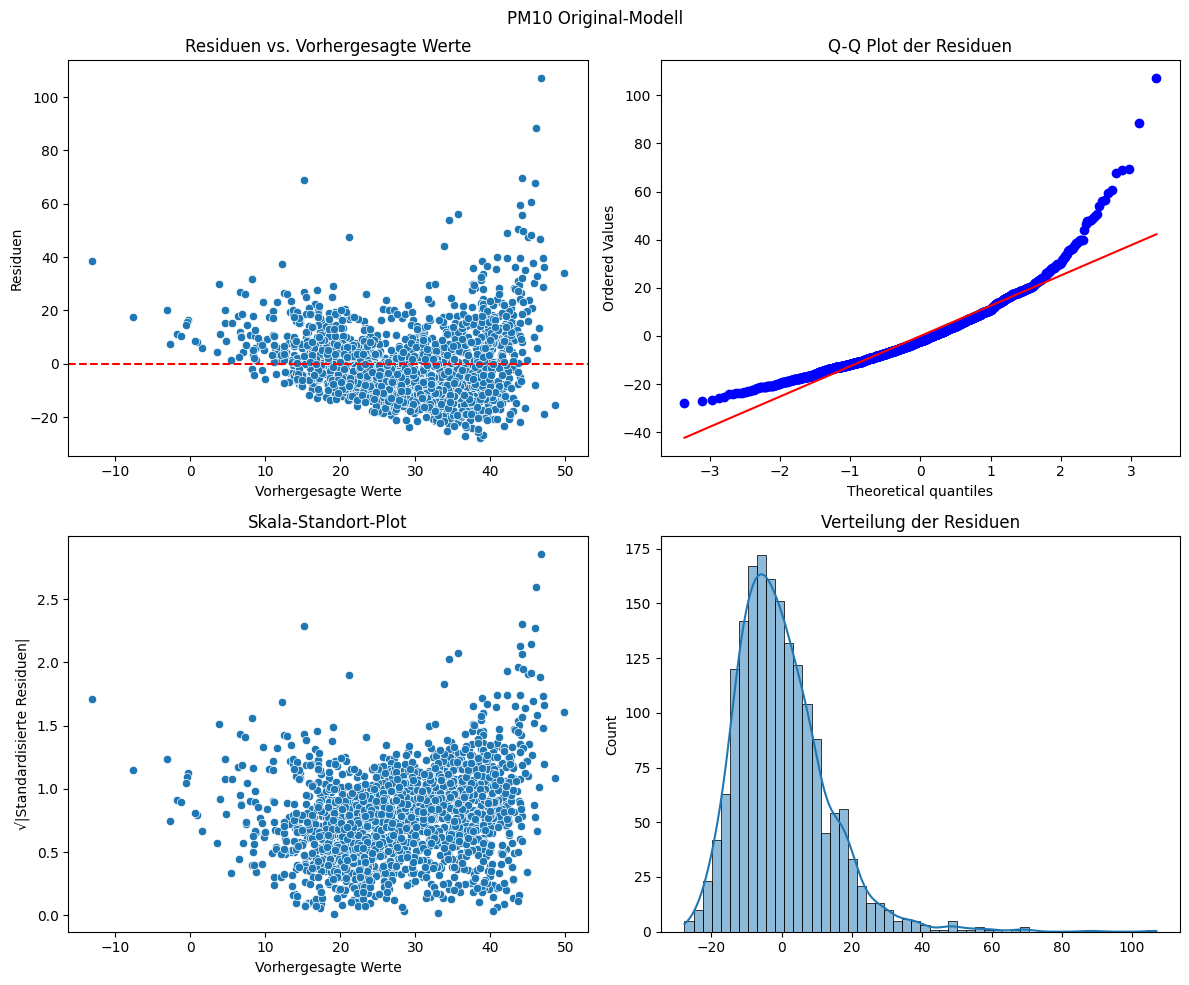

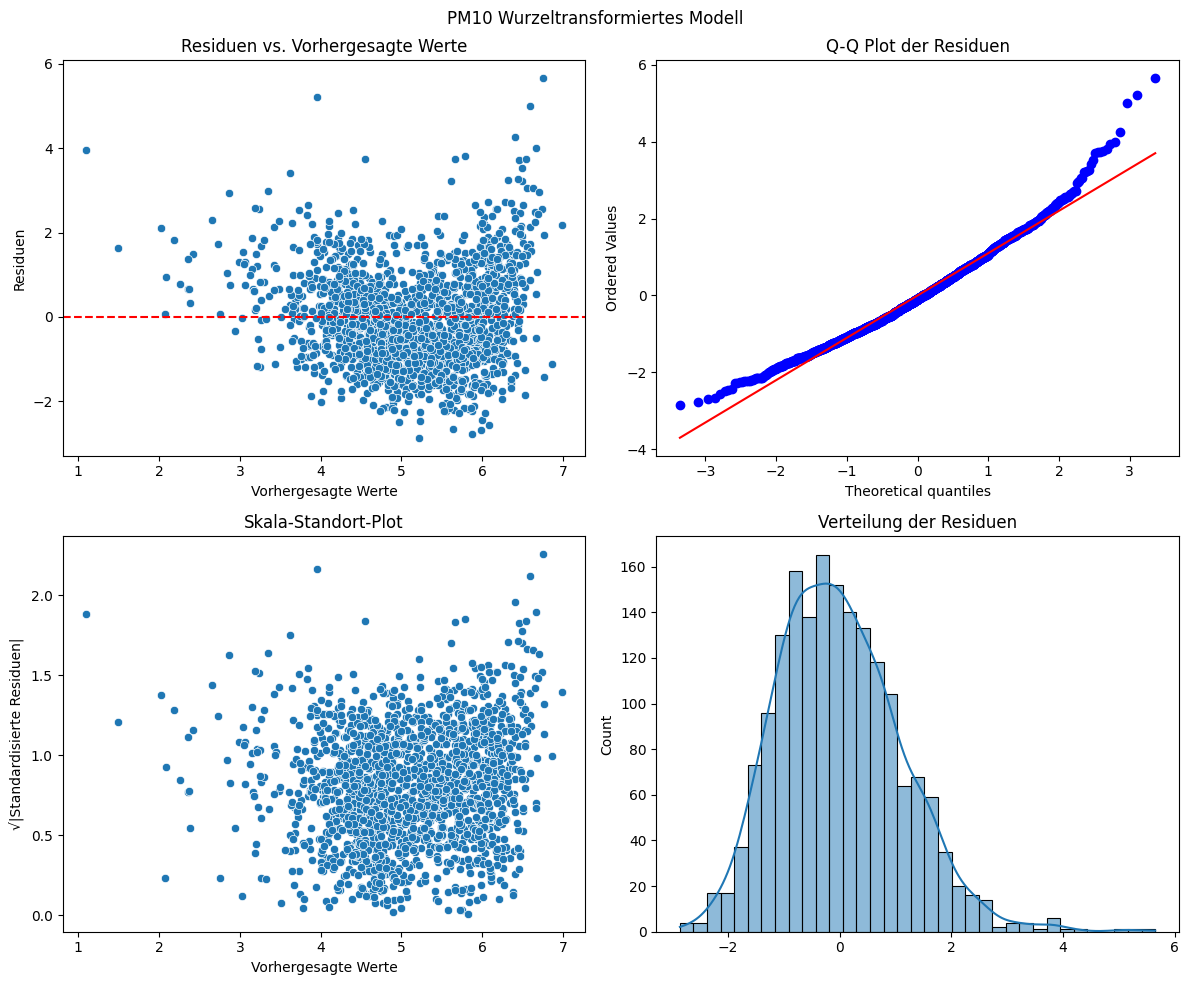

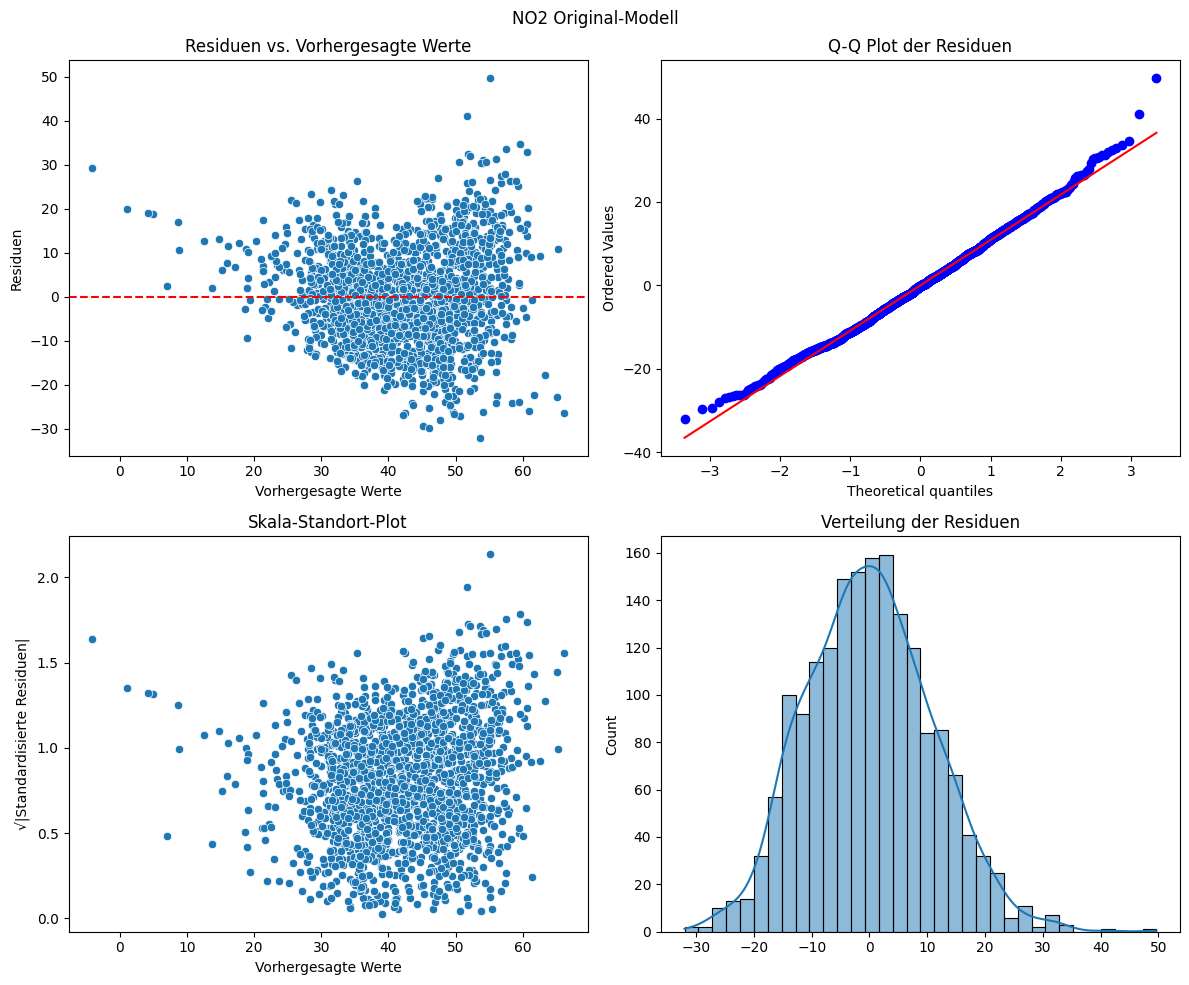

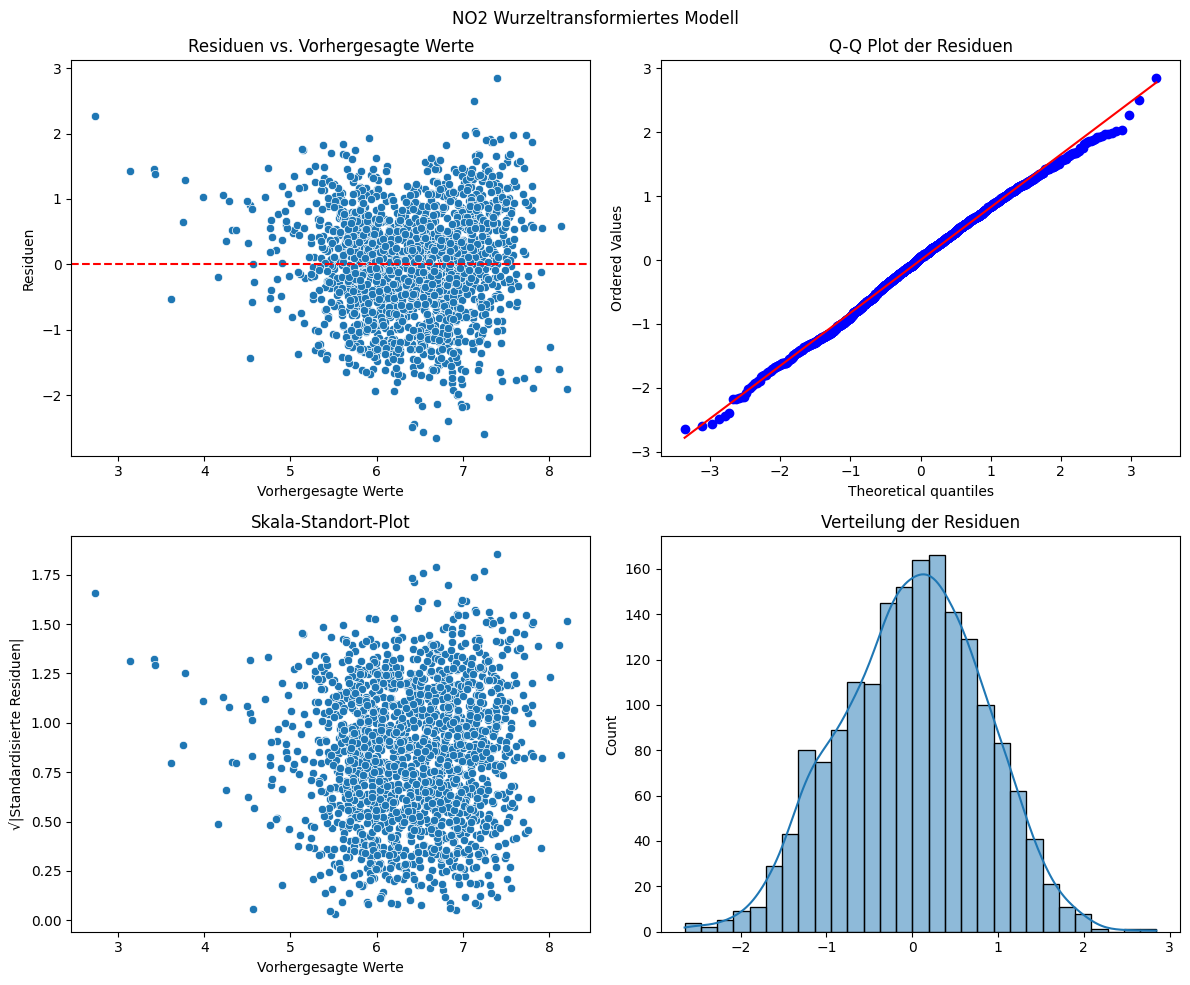


=== Shapiro-Wilk-Test der Residuen ===
PM10 Original: ShapiroResult(statistic=0.9176054932016984, pvalue=4.0073018947038316e-30)
PM10 Wurzel: ShapiroResult(statistic=0.9812644635434444, pvalue=1.580771843710961e-14)
NO2 Original: ShapiroResult(statistic=0.9962787557031998, pvalue=0.0002256523741514646)
NO2 Wurzel: ShapiroResult(statistic=0.9971010027683719, pvalue=0.002016820763372734)


In [21]:
###############################################################################
# 5) Vergleich Model mit und ohne Wurzel
###############################################################################

def erstelle_modelle_mit_transformation(df, zielvariable, praediktoren):
    """Erstellt und vergleicht Modelle mit und ohne Wurzeltransformation"""
    
    # Original-Modell
    formel_original = f"{zielvariable} ~ " + " + ".join(praediktoren)
    modell_original = ols(formel_original, data=df).fit()
    
    # Modell mit Wurzeltransformation
    df[f'sqrt_{zielvariable}'] = np.sqrt(df[zielvariable])
    formel_wurzel = f"sqrt_{zielvariable} ~ " + " + ".join(praediktoren)
    modell_wurzel = ols(formel_wurzel, data=df).fit()
    
    return modell_original, modell_wurzel

def erstelle_diagnostik_plots(modell, titel):
    """Erstellt diagnostische Plots für das Modell"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuen vs. Fitted
    sns.scatterplot(x=modell.fittedvalues, y=modell.resid, ax=ax1)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Vorhergesagte Werte')
    ax1.set_ylabel('Residuen')
    ax1.set_title('Residuen vs. Vorhergesagte Werte')
    
    # Q-Q Plot
    stats.probplot(modell.resid, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot der Residuen')
    
    # Skala-Standort-Plot
    sns.scatterplot(x=modell.fittedvalues, y=np.sqrt(np.abs(modell.resid_pearson)), ax=ax3)
    ax3.set_xlabel('Vorhergesagte Werte')
    ax3.set_ylabel('√|Standardisierte Residuen|')
    ax3.set_title('Skala-Standort-Plot')
    
    # Residuen-Verteilung
    sns.histplot(modell.resid, kde=True, ax=ax4)
    ax4.set_title('Verteilung der Residuen')
    
    plt.suptitle(titel)
    plt.tight_layout()
    return fig

# Basisprädikatoren definieren
praediktoren = ['temp', 'humidity', 'prec', 'windspeed', 'peak_velocity']

# Trainingsdaten vorbereiten (2015-2019)
mask = (df_graz.index.year >= 2015) & (df_graz.index.year <= 2019)
train_df = df_graz[mask].copy()

# Modelle für PM10
pm10_original, pm10_wurzel = erstelle_modelle_mit_transformation(train_df, 'pm10', praediktoren)

# Modelle für NO2
no2_original, no2_wurzel = erstelle_modelle_mit_transformation(train_df, 'no2', praediktoren)

# Ergebnisse ausgeben
print("=== PM10 Modellvergleich ===")
print(f"R² Original: {pm10_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {pm10_wurzel.rsquared:.3f}")
print(f"AIC Original: {pm10_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {pm10_wurzel.aic:.1f}")

print("\n=== NO2 Modellvergleich ===")
print(f"R² Original: {no2_original.rsquared:.3f}")
print(f"R² Wurzeltransformation: {no2_wurzel.rsquared:.3f}")
print(f"AIC Original: {no2_original.aic:.1f}")
print(f"AIC Wurzeltransformation: {no2_wurzel.aic:.1f}")

# Diagnostik-Plots erstellen
diagnostik_pm10_original = erstelle_diagnostik_plots(pm10_original, "PM10 Original-Modell")
diagnostik_pm10_wurzel = erstelle_diagnostik_plots(pm10_wurzel, "PM10 Wurzeltransformiertes Modell")
diagnostik_no2_original = erstelle_diagnostik_plots(no2_original, "NO2 Original-Modell")
diagnostik_no2_wurzel = erstelle_diagnostik_plots(no2_wurzel, "NO2 Wurzeltransformiertes Modell")

plt.show()

# Shapiro-Wilk-Test für Normalität der Residuen
print("\n=== Shapiro-Wilk-Test der Residuen ===")
print("PM10 Original:", stats.shapiro(pm10_original.resid))
print("PM10 Wurzel:", stats.shapiro(pm10_wurzel.resid))
print("NO2 Original:", stats.shapiro(no2_original.resid))
print("NO2 Wurzel:", stats.shapiro(no2_wurzel.resid))

# Versuch der Verbesserung des AIC durch Wurzeltransfomation: zeigt deutliche Verbesserungen sowohl bei NO² als auch bei pm10

Vorhersagen für 2020 (erste Zeilen):
                 pm10  predicted_pm10        no2  predicted_no2
DateTime                                                       
2020-01-01  57.594240       37.317413  39.827072      48.942816
2020-01-02  51.521755       42.381981  56.696457      56.935116
2020-01-03  52.611362       43.041533  66.766790      57.051817
2020-01-04  40.989760       37.139315  52.037860      54.349055
2020-01-05  16.188208       26.039769  32.097057      43.203353


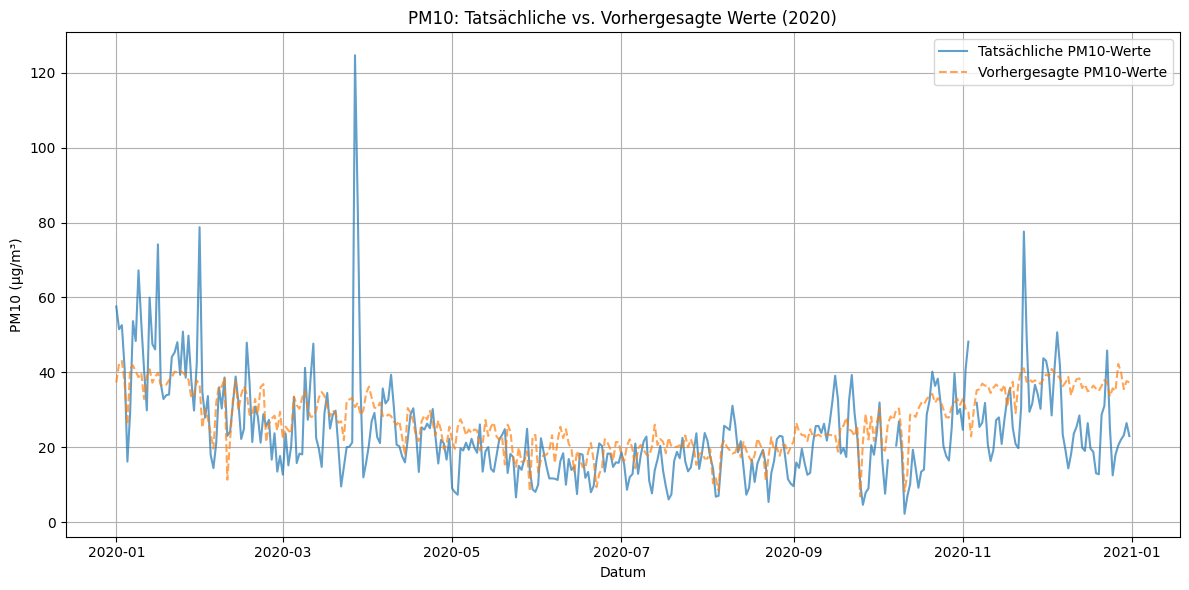

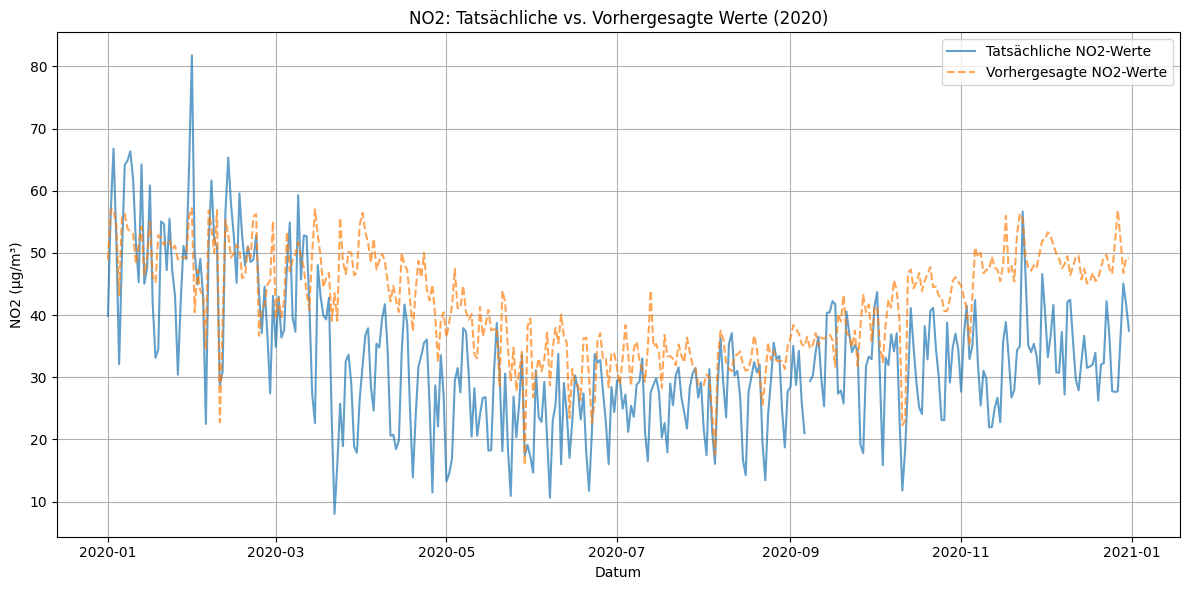

In [ ]:
###############################################################################
# 6) Modell aus Punkt 5 wird für die Vorhersage 2020 benutzt 
###############################################################################

# Testdaten für das Jahr 2020 vorbereiten
mask_2020 = (df_graz.index.year == 2020)
test_df = df_graz[mask_2020].copy()

# Vorhersage mit Wurzeltransformation für PM10
# Das  Modell `pm10_wurzel` aus Punkt 5 wird hier verwendet.
# Es wird auf die Prädiktoren angewendet, um die Vorhersage auf der Wurzelskala zu berechnen.
test_df['predicted_sqrt_pm10'] = pm10_wurzel.predict(test_df[praediktoren])

# Rücktransformation: Vorhersagewerte von der Wurzelskala auf die Originalskala zurückführen
test_df['predicted_pm10'] = test_df['predicted_sqrt_pm10'] ** 2

# Vorhersage mit Wurzeltransformation für NO2
# Das Modell `no2_wurzel` aus Punkt 5 wird hier verwendet.
# Es wird auf die Prädiktoren angewendet, um die Vorhersage auf der Wurzelskala zu berechnen.
test_df['predicted_sqrt_no2'] = no2_wurzel.predict(test_df[praediktoren])

# Rücktransformation: Vorhersagewerte von der Wurzelskala auf die Originalskala zurückführen
test_df['predicted_no2'] = test_df['predicted_sqrt_no2'] ** 2

# Ergebnisse anzeigen
print("Vorhersagen für 2020 (erste Zeilen):")
# Hier werden die tatsächlichen Werte (`pm10`, `no2`) mit den vorhergesagten Werten (`predicted_pm10`, `predicted_no2`) verglichen.
print(test_df[['pm10', 'predicted_pm10', 'no2', 'predicted_no2']].head())

# Visualisierung mit PM10
plt.figure(figsize=(12, 6))
# Tatsächliche PM10-Werte für 2020
plt.plot(test_df.index, test_df['pm10'], label='Tatsächliche PM10-Werte', alpha=0.7)
# Vorhergesagte PM10-Werte für 2020, basierend auf dem Modell `pm10_wurzel`
plt.plot(test_df.index, test_df['predicted_pm10'], label='Vorhergesagte PM10-Werte', linestyle='--', alpha=0.7)
plt.title("PM10: Tatsächliche vs. Vorhergesagte Werte (2020)")
plt.xlabel("Datum")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Visualisierung mit NO2
plt.figure(figsize=(12, 6))
# Tatsächliche NO2-Werte für 2020
plt.plot(test_df.index, test_df['no2'], label='Tatsächliche NO2-Werte', alpha=0.7)
# Vorhergesagte NO2-Werte für 2020, basierend auf dem Modell `no2_wurzel`
plt.plot(test_df.index, test_df['predicted_no2'], label='Vorhergesagte NO2-Werte', linestyle='--', alpha=0.7)
plt.title("NO2: Tatsächliche vs. Vorhergesagte Werte (2020)")
plt.xlabel("Datum")
plt.ylabel("NO2 (µg/m³)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Zeigt eine einigermaßen gute Vorhersage gemessen an der relative schlechten Adj. R-squared.
# Eindeutig erkennbar ist der Effekt von COVID-19 im März-April 2020 (erster Lockdown) bei NO² hier wurde der tatsächliche Wert von unserem Modell deutlich überschätzt.
# zudem sieht man auch die Effekte des zweiten Lockdowns beginnend im November des selben Jahres.

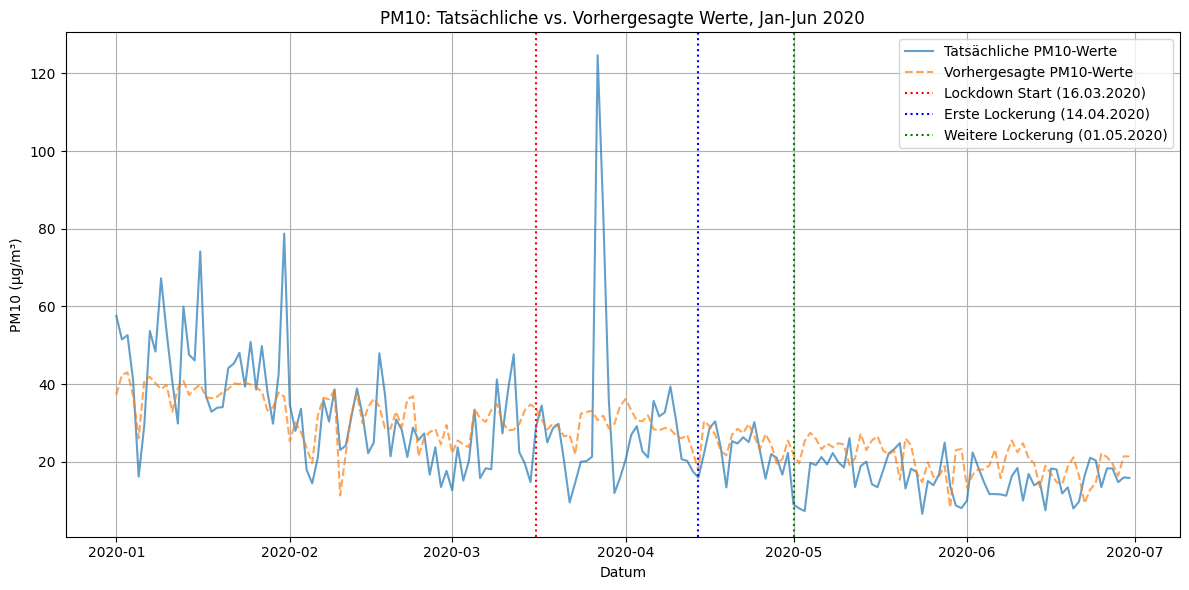

In [34]:
###############################################################################
# 7) Vergleichen der Vorhersage für 2020 mit den wahren Werten aus 2020
###############################################################################

# Nur Daten von Januar bis Juni 2020
test_df_6m = test_df.loc["2020-01-01":"2020-06-30"].copy()

lockdown_start = pd.to_datetime("2020-03-16")
lockdown_easing1 = pd.to_datetime("2020-04-14")
lockdown_easing2 = pd.to_datetime("2020-05-01")


plt.figure(figsize=(12, 6))
plt.plot(test_df_6m.index, test_df_6m['pm10'], label='Tatsächliche PM10-Werte', alpha=0.7)
plt.plot(test_df_6m.index, test_df_6m['predicted_pm10'], 
         label='Vorhergesagte PM10-Werte', linestyle='--', alpha=0.7)

plt.axvline(lockdown_start, color='red', linestyle=':', label='Lockdown Start (16.03.2020)')
plt.axvline(lockdown_easing1, color='blue', linestyle=':', label='Erste Lockerung (14.04.2020)')
plt.axvline(lockdown_easing2, color='green', linestyle=':', label='Weitere Lockerung (01.05.2020)')

plt.title("PM10: Tatsächliche vs. Vorhergesagte Werte, Jan-Jun 2020")
plt.xlabel("Datum")
plt.ylabel("PM10 (µg/m³)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

